# Implementing Random Forest

Authors:
- Nooruddin Shaikh
- Milind Sai
- Saurabh Jejurkar
- Kartik Bhargav

In [11]:
#Importing Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from  sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
from datetime import datetime
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
data = pd.read_csv("Data/final_data.csv")
data.head()

,PM2.5,NO2,CO,SO2,O3,AQI
0,83.13,28.71,6.93,49.52,59.76,209.0
1,79.84,28.68,13.85,48.49,97.07,328.0
2,94.52,32.66,24.39,67.39,111.33,514.0
3,135.99,42.08,43.48,75.23,102.70,782.0
4,178.33,35.31,54.56,55.04,107.38,914.0


We have tried every combination and found this one is best. Here we will first split our data into 95% and 5%. The 5% data will be unseen and hidden or separated. Then from that 95% we will again split the data into 80% and 20% as a train and test split. here are implementing custom Cross validation to avoid Data Leakages.

In [6]:
#Splitting data as X and y
X = data.iloc[:, :-1] #Independent features
y = data.iloc[:, -1] #Dependent feature

In [8]:
#Splitting and separating 5% data and making it as unseen
X_train_unseen, X_test_unseen, y_train_unseen, y_test_unseen = train_test_split(X, y, test_size=0.05,random_state=1)
len(X_train_unseen),len(X_test_unseen)

(21487, 1131)

In [9]:
# Splitting that 95% data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_train_unseen, y_train_unseen, test_size=0.20,random_state=1)

<AxesSubplot:xlabel='PM2.5'>

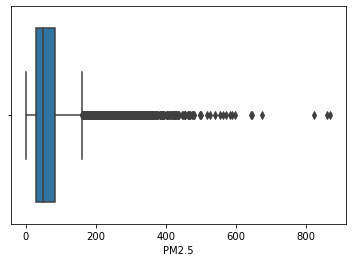

In [10]:
sns.boxplot(X_train['PM2.5'])

In [13]:
# Fitting Model without any tunning
model = RandomForestRegressor(n_estimators = 200, random_state = 0)
model = model.fit(X_train, y_train)
prediction = model.predict(X_test)

print("Coefficient of Determination (R^2) for train dataset: ", model.score(X_train, y_train))
print("Coefficient of Determination (R^2) for test dataset: ", model.score(X_test, y_test))

print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

Coefficient of Determination (R^2) for train dataset:  0.985058318248108
Coefficient of Determination (R^2) for test dataset:  0.9012620423248175
MAE: 23.891990460679384
MSE: 1983.8256185842256
RMSE: 44.54015737044747


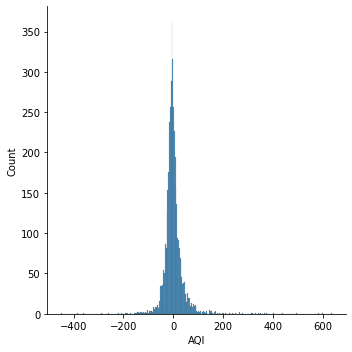

In [14]:
sns.displot(y_test - prediction)

The model is overfitted with 98.5% accuracy on trining but 90% on testing. Let's tune the hyperparameter and see if the model can be generalized

# After Hyper Parameter Tuning

In [15]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=18)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num=6)]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10,12]
params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

In [16]:
rf = RandomForestRegressor()
tuned_model = RandomizedSearchCV(rf, params, scoring='neg_mean_squared_error', 
                            cv=5, n_iter=20, random_state=43, n_jobs=-1)

In [17]:
tuned_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10, 12],
                                        'n_estimators': [100, 164, 229, 294,
                                                         358, 423, 488, 552,
                                                         617, 682, 747, 811,
                                                         876, 941, 1005, 1070,
                                                         1135, 1200]},
                   random_state=43, scoring='neg_mean_squared_error')

In [19]:
#Printing Best Parameter during tunning
print(tuned_model.best_estimator_)

RandomForestRegressor(max_depth=25, max_features='sqrt', n_estimators=552)


In [20]:
# Now using the best parameter and predicting
best_rf = RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=552)

In [21]:
best_rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=552)

In [22]:
print("Coefficient of Determination (R^2) for train dataset: ", best_rf.score(X_train, y_train))
print("Coefficient of Determination (R^2) for test dataset: ", best_rf.score(X_test, y_test))

Coefficient of Determination (R^2) for train dataset:  0.9188685163116478
Coefficient of Determination (R^2) for test dataset:  0.8937548328269249


# Prediction

In [26]:
X_test_unseen.head()

,PM2.5,NO2,CO,SO2,O3
14349,38.82,26.56,0.82,10.25,20.06
12364,63.58,40.25,0.23,27.84,50.72
19768,62.33,2.60,0.59,7.46,29.58
8955,118.43,84.21,0.89,37.55,39.59
4563,37.67,37.32,1.06,7.06,34.92


In [28]:
y_test_unseen.head()

14349     74.0
12364    141.0
19768    111.0
8955     421.0
4563      84.0
Name: AQI, dtype: float64

In [78]:
print(model.predict([[38.82,26.56,0.82,10.25,20.06]]))
print(model.predict([[63.58,40.25,0.23,27.84,50.72]]))
print(model.predict([[62.33,2.60,0.59,7.46,29.58]]))
print(model.predict([[118.43,84.21,0.89,37.55,39.59]]))
print(model.predict([[37.67,37.32,1.06,7.06,34.92]]))

[98.075]
[141.845]
[114.91]
[303.745]
[100.03]


# Insights
- Random Forest is much better and more generalized than Decision Tree.
- RF giving 91.8% on train and 89% on test data
- We can see in the prediction, 421 is predicted as 304, this explain there are outlier in the AQI. Although RF is not affected by Outlier, but as per domain knowledge we know that if AQI is greater than 300, it is severe.
- In the next part, we can try to handle large values and see the prediction